# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Load Data

In [3]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/24 12:29:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Define Spark Schema
schema = StructType([StructField('ID', StringType(), False),
                StructField('Source', StringType(), False),
                StructField('Severity', IntegerType(), False),
                StructField('Start_Time', TimestampType(), False),                  
                StructField('End_Time', TimestampType(), False),      
                StructField('Start_Lat', DecimalType(), False),
                StructField('Start_Lng', DecimalType(), False),
                StructField('End_Lat', DecimalType(), True),
                StructField('End_Lng', DecimalType(), True),       
                StructField('Distance(mi)', DecimalType(), False),       
                StructField('Description', StringType(), False),       
                StructField('Street', StringType(), True),                 
                StructField('City', StringType(), True),       
                StructField('County', StringType(), True),       
                StructField('State', StringType(), True),       
                StructField('Zipcode', StringType(), True),       
                StructField('Country', StringType(), True),       
                StructField('Timezone', StringType(), True),       
                StructField('Airport_Code', StringType(), True),
                StructField('Weather_Timestamp', TimestampType(), True),
                StructField('Temperature(F)', DecimalType(), True),
                StructField('Wind_Chill(F)', DecimalType(), True),
                StructField('Humidity(%)', DecimalType(), True),
                StructField('Pressure(in)', DecimalType(), True),
                StructField('Visibility(mi)', DecimalType(), True),
                StructField('Wind_Direction', StringType(), True),
                StructField('Wind_Speed(mph)', DecimalType(), True),
                StructField('Precipitation(in)', DecimalType(), True),
                StructField('Weather_Condition', StringType(), True),
                StructField('Amenity', BooleanType(), False),
                StructField('Bump', BooleanType(), False),
                StructField('Crossing', BooleanType(), False),
                StructField('Give_way', BooleanType(), False),
                StructField('Junction', BooleanType(), False),
                StructField('No_Exit', BooleanType(), False),
                StructField('Railway', BooleanType(), False), 
                StructField('Roundabout', BooleanType(), False),
                StructField('Station', BooleanType(), False),
                StructField('Stop', BooleanType(), False),
                StructField('Traffic_Calming', BooleanType(), False),
                StructField('Traffic_Signal', BooleanType(), False),
                StructField('Turning_Loop', BooleanType(), False),
                StructField('Sunrise_Sunset', StringType(), True),
                StructField('Civil_Twilight', StringType(), True),
                StructField('Nautical_Twilight', StringType(), True),
                StructField('Astronomical_Twilight', StringType(), True)])

# Use the DataFrameReader interface to read a CSV file
file = "US_Accidents_March23.csv"
df = spark.read.csv(file, header=True, schema=schema)

In [5]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7728394
DataFrame Columns count : 46


In [6]:
#Summary stats of all columns (takes forever to run)
#df.summary().show()

# Nulls

In [7]:
#Null counts (excluding time columns)
df.agg(*[
    (rows-count(c)).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns 
]).show()

24/10/24 12:29:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twil

In [8]:
#have to remove the ~8000 rows with null timezone if using date/time in any way
df = df.dropna(subset=["Timezone"])
df.groupBy('Timezone').count().orderBy(desc("count")).show()

+-----------+-------+
|   Timezone|  count|
+-----------+-------+
| US/Eastern|3580167|
| US/Pacific|2062984|
| US/Central|1645616|
|US/Mountain| 431819|
+-----------+-------+



# Engineer Weather and Time Columns

In [9]:
# Create Day of the Week Column
df = df.withColumn('Day_of_Week', dayofweek(col('Start_Time'))) #Ranges from 1 for a Sunday through to 7 for a Saturday

# Create Weekday Column (1 = Weekday, 0 = Weekend)
df = df.withColumn(
    'Weekday',
    F.when(F.col("Day_of_Week").between(2, 6), 1)\
    .otherwise(0))

df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Cross

In [10]:
# Create Month Column
df = df.withColumn('Month', month(df['Start_Time']))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump

In [11]:
# Create Season Column
df = df.withColumn(
    'Season',
    F.when(F.col("Month").between(3, 5), 'Spring')\
    .when(F.col("Month").between(6, 8), 'Summer')\
    .when(F.col("Month").between(9, 11), 'Fall')\
    .otherwise('Winter'))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenit

In [12]:
# Create Rush Hour Column
# defined as 6-9am and 4-7pm (https://www.goldlaw.com/how-deadly-is-rush-hour/)
df = df.withColumn('Start_Time_Time', date_format('Start_Time', 'HH:mm:ss'))
df.show(5)
df = df.withColumn(
    'Rush Hour',
    F.when(F.col('Start_Time_Time').between('06:00:00', '09:00:00'), 1)\
    .when(F.col('Start_Time_Time').between('16:00:00', '19:00:00'), 1)\
    .otherwise(0))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_

In [13]:
# Create Date Column from Start Date
df = df.withColumn('Start_Date_Date', date_format('Start_Time', 'yyyy-MM-dd'))

#Create list of holiday dates for span of data (2016-2023)
#!pip3 install holidays
import holidays
from datetime import datetime, timezone
h = []
for ptr in holidays.UnitedStates(years = [2016,2017,2018,2019,2020,2021,2022,2023]).items(): 
    h.append(ptr[0].strftime("%Y-%m-%d"))

# Create Holiday column    
df = df.withColumn(
    'Holiday',
    F.when(array_contains(lit(h), F.col("Start_Date_Date")), 1)\
    .otherwise(0))
df.show(5) 

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+---------------+-------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Spe

In [14]:
# Create columns for rain and snow from weather_condition column

rain_values = ['Rain', 'Drizzle', 'Mist', 'N/A Precipitation']
snow_values = ['Ice', 'Snow', 'Hail', 'Sleet', 'Wintry Mix', 'Freezing Rain', 'Freezing Drizzle']

condition = F.when(F.col('Weather_Condition').rlike("|".join(rain_values)), 1).otherwise(0)
df = df.withColumn("Rain", condition)

condition = F.when(F.col('Weather_Condition').rlike("|".join(snow_values)), 1).otherwise(0)
df = df.withColumn("Snow", condition)

df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+---------------+-------+----+----+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Directio

# Encoding Categorical Variables

In [15]:
# Encode Season
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Create a StringIndexer
indexer = StringIndexer(inputCol="Season", outputCol="SeasonIndex")
indexed = indexer.fit(df).transform(df)

# Create a OneHotEncoder
encoder = OneHotEncoder(inputCols=["SeasonIndex"], outputCols=["SeasonVec"])
df = encoder.fit(indexed).transform(indexed)

# Show the result
df.show()

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+---------------+-------+----+----+-----------+-------------+
|  ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|

In [16]:
df.show()

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+---------------+-------+----+----+-----------+-------------+
|  ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|

In [17]:
#Encode Day/Night to 1/0
for x in enumerate(['Sunrise_Sunset'
               , 'Civil_Twilight'
               , 'Nautical_Twilight'
               , 'Astronomical_Twilight']):
    # Create a StringIndexer instance
    indexer = StringIndexer(inputCol=x[1], outputCol=f"{x[1]}Index").setHandleInvalid("keep")

    # Fit the indexer to the data
    model = indexer.fit(df)

    # Transform the data to include the indexed column
    df = model.transform(df)

In [18]:
# Change Data Type
for x in enumerate(['Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex']):
    df = df.withColumn(x[1], col(x[1]).cast("int"))
df.show(10)

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+---------------+-------+----+----+-----------+-------------+-------------------+-------------------+----------------------+--------------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezo

# Engineering Other Columns

In [19]:
# Layla - highway vs not highway column

# Correlations

24/10/24 12:30:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


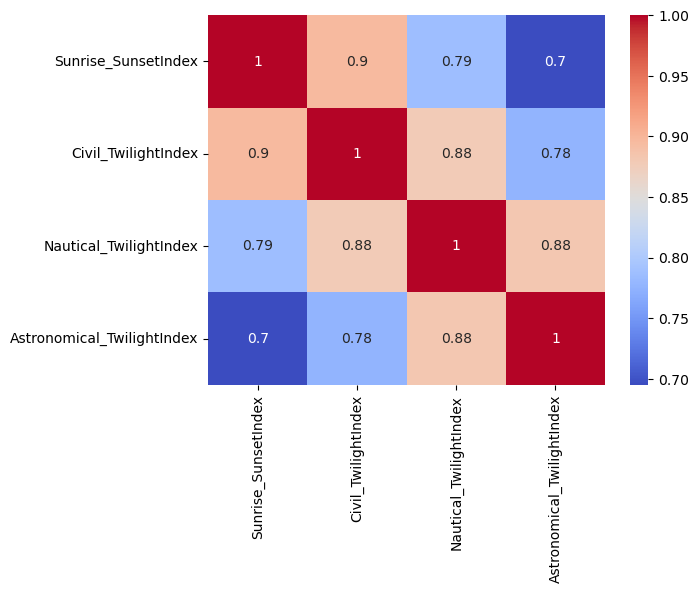

In [20]:
# Correlations - Day/Night Columns
# Select Relevant Columns
df1 = df.select('Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex')
df1 = df1.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex'], outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)

#Plot
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm")
plt.show()

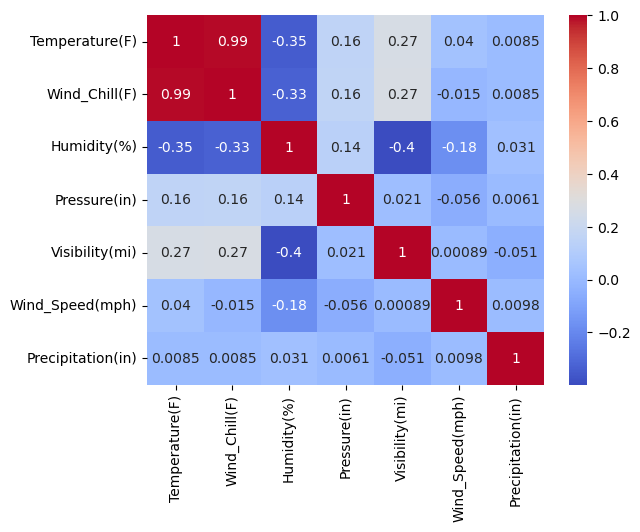

In [21]:
# Correlations - Weather Columns
# Select Relevant Columns
df1 = df.select('Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)')
df1 = df1.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)'], outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)

#Plot
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm")
plt.show()

In [22]:
# Add POI correlations from Kaleigh

# Add Demographic Columns based on Zipcode

In [23]:
# Add code from Layla here

# Initial Column Removal

In [24]:
#List all columns
print(df.columns)

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Day_of_Week', 'Weekday', 'Month', 'Season', 'Start_Time_Time', 'Rush Hour', 'Start_Date_Date', 'Holiday', 'Rain', 'Snow', 'SeasonIndex', 'SeasonVec', 'Sunrise_SunsetIndex', 'Civil_TwilightIndex', 'Nautical_TwilightIndex', 'Astronomical_TwilightIndex']


In [45]:
# Initial Column Removal
df = df.drop(
            'ID'
             , 'Source' # Not useful?
             #, 'Severity'
             , 'Start_Time' # Used to calculate Rush Hour and Holiday Columns
             , 'End_Time'
             , 'Start_Lat'
             , 'Start_Lng'
             , 'End_Lat'
             , 'End_Lng'
             , 'Distance(mi)' # Data leakage issue - captured after accident occured
             , 'Description' # Captures little new data
             , 'Street' # Not useful for prediction
             , 'City'
             , 'County'
             , 'State'
             , 'Zipcode'
             , 'Country' # 100% US
             , 'Timezone' # Not for prediction
             , 'Airport_Code' # Not for prediction
             , 'Weather_Timestamp' # Not for prediction
             #, 'Temperature(F)'
             , 'Wind_Chill(F)' # 99% correlated with Temperature(F)
             #, 'Humidity(%)'
             #, 'Pressure(in)'
             #, 'Visibility(mi)'
             , 'Wind_Direction' # Not useful?
             #, 'Wind_Speed(mph)'
             #, 'Precipitation(in)'
             , 'Weather_Condition' # Turning into binary columns for rain and snow
             #, 'Amenity' #1% true
             #, 'Bump' #0% true
             #, 'Crossing' #11% true
             #, 'Give_way' #0% true
             #, 'Junction' #7% true
             #, 'No_Exit' #0% true
             #, 'Railway' #1% true
             #, 'Roundabout' #0% true
             #, 'Station' #3% true
             #, 'Stop' #3% true
             #, 'Traffic_Calming' #0% true
             #, 'Traffic_Signal' #15% true
             , 'Turning_Loop' # 100% False (not a single true value)
             , 'Sunrise_Sunset' # Highly correlated with other day/night variables
             , 'Civil_Twilight' # Highly correlated with other day/night variables
             , 'Nautical_Twilight' # Highly correlated with other day/night variables
             , 'Astronomical_Twilight' # True Night - removing to keep index column
             , 'Day_of_Week' # Used to create Weekday column
             #, 'Weekday'
             , 'Month' # Use Season instead
             , 'Season' #Used to create SeasonVec
             , 'Start_Time_Time' #Used to calculate Rush Hour Column
             #, 'Rush Hour'
             , 'Start_Date_Date' #Used to calculate Holiday Column
             #, 'Holiday'
             #, 'Snow'
             #, 'Rain'
             , 'Sunrise_SunsetIndex' # Highly correlated with other day/night variables
             , 'Civil_TwilightIndex' # Highly correlated with other day/night variables
             , 'Nautical_TwilightIndex' # Highly correlated with other day/night variables
             #, 'Astronomical_TwilightIndex' # True Night
             , 'SeasonIndex'
             #, 'SeasonVec'
            )
df.show(5)

+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+-------+----+----+-------------+--------------------------+--------------------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Holiday|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|            features|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+-------+----+----+-------------+--------------------------+--------------------+
|       3|            38|         97|          30|             7|  

# Further Column Removal and Preprocessing

### Nulls

In [26]:
rows = df.count()
print(rows)

#Null counts
df.agg(*[
    (rows-count(c)).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns 
]).show()

7720586


+---+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-------+---------+-------+----+----+---------+--------------------------+
| ID|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Holiday|Rain|Snow|SeasonVec|Astronomical_TwilightIndex|
+---+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-------+---------+-------+----+----+---------+--------------------------+
|  0|       0|        156045|     166336|      132871|        169290|         563425|          2195778|      0|   0|       0|       0|  

In [27]:
# Remove Nulls
df = df.dropna()
rows = df.count()
print(rows)
df.show()

5400564
+----+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+-------+----+----+-------------+--------------------------+
|  ID|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Holiday|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|
+----+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+-------+----+----+-------------+--------------------------+
| A-6|       3|            38|         97|          30|             7|              4|                0|  f

### Too few data points (POIs)

In [28]:
from pyspark.sql.functions import sum
df.select(((sum(df.Amenity.cast("long"))/rows)*100).alias('Amenity % True'), 
          ((sum(df.Bump.cast("long"))/rows)*100).alias('Bump % True'),
          ((sum(df.Crossing.cast("long"))/rows)*100).alias('Crossing % True'), 
          ((sum(df.Give_way.cast("long"))/rows)*100).alias('Give Way % True'),
          ((sum(df.Junction.cast("long"))/rows)*100).alias('Junction % True'), 
          ((sum(df.No_Exit.cast("long"))/rows)*100).alias('No Exit % True'),
          ((sum(df.Railway.cast("long"))/rows)*100).alias('Railway % True'), 
          ((sum(df.Roundabout.cast("long"))/rows)*100).alias('Roundabout % True'),
          ((sum(df.Station.cast("long"))/rows)*100).alias('Station % True'), 
          ((sum(df.Stop.cast("long"))/rows)*100).alias('Stop % True'),
          ((sum(df.Traffic_Calming.cast("long"))/rows)*100).alias('Traffic Calming % True'), 
          ((sum(df.Traffic_Signal.cast("long"))/rows)*100).alias('Traffic Signal % True')
    ).show()

+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+--------------------+------------------+------------------+----------------------+---------------------+
|    Amenity % True|       Bump % True|   Crossing % True|  Give Way % True|  Junction % True|     No Exit % True|    Railway % True|   Roundabout % True|    Station % True|       Stop % True|Traffic Calming % True|Traffic Signal % True|
+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+--------------------+------------------+------------------+----------------------+---------------------+
|1.1993932485570025|0.0503465934298714|10.810537566076432|0.432065984219426|6.918777372141132|0.26000988044952345|0.8320797605583417|0.002925620361132...|2.6556855913567547|2.7462316898753536|   0.10326699211415696|   13.003938107205098|
+------------------+------------------+---------

In [29]:
df.summary().show()

+-------+--------+-------------------+------------------+----------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------------+
|summary|      ID|           Severity|    Temperature(F)|     Humidity(%)|     Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|  Precipitation(in)|            Weekday|         Rush Hour|            Holiday|               Rain|               Snow|Astronomical_TwilightIndex|
+-------+--------+-------------------+------------------+----------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------------+
|  count| 5400564|            5400564|           5400564|         5400564|          5400564|           5400564|           5400564|            5400564|            5400564

### Correlation between Features and Target

In [51]:
from pyspark.sql.functions import corr

def correlation_with_target(df, target_column):
    """Calculates correlation between all columns and the target column."""
    correlations = {}
    for col in df.columns:
        if col != target_column:
            correlations[col] = df.stat.corr(target_column, col)
    return correlations

#Remove booleans - pyspark doesn't support
#IllegalArgumentException: requirement failed: Currently correlation calculation for columns with dataType boolean not supported.
df_cols = df.select(['Severity', 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)'])


correlations = correlation_with_target(df_cols, "Severity")

for col, corr_value in correlations.items():
    print(f"Correlation between {col} and target: {corr_value}")

Correlation between Temperature(F) and target: -0.022404845974558135
Correlation between Humidity(%) and target: 0.0359154166958176
Correlation between Pressure(in) and target: -0.023305140120555397
Correlation between Visibility(mi) and target: -0.029769805115014616
Correlation between Wind_Speed(mph) and target: 0.02893778115421944
Correlation between Precipitation(in) and target: 0.008482145384190638


### Outliers

In [69]:
def outliers(df, col):
    
    # Calculate quantiles
    q1, q3 = df.approxQuantile(col, [0.15, 0.95], 0.01) #arguably not quartiles anymore but changed to only pick up more extreme outliers
    iqr = q3 - q1

    # Define outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df.filter((df[col] < lower_bound) | (df[col] > upper_bound))

    outliers_df[col] = outliers
    outliers.select(col).show()

In [70]:
col = 'Temperature(F)'
 #'Humidity(%)',
 #'Pressure(in)',
 #'Visibility(mi)',
 #'Wind_Speed(mph)',
 #'Precipitation(in)'

out = outliers(df, col)
print(out)

+--------------+
|Temperature(F)|
+--------------+
|           196|
|           196|
|           -36|
|           189|
|           174|
|           174|
|           -35|
|           -35|
|           -38|
|           -35|
|           -35|
|           162|
|           -35|
|           -35|
|           172|
|           -45|
|           -35|
|           162|
|           -35|
|           -38|
+--------------+
only showing top 20 rows

None


# Modeling

In [ ]:
### Scaling
### Dealing with class imbalance during training